# Topology of BSD parameters

Recall the BSD formula - 
$$\mathrm{Sha}(E_D) = \frac{16 L(1, E_D)}{\Omega(E_D) \mathrm{Reg}(E) \prod_p c_p}, $$
where
- $\mathrm{Sha}$ is the Tate-Shafarevich group
- $L(1, E_D)$ is the special value,
- $\Omega(E_D)$ is the real period, 
- $\mathrm{Reg}(E_D)$ is the regulators, 
- $\prod_p c_p$ is the Tamagawa product,
- and $16$ is the square of the torsion order.

In this notebook we study the $5$-dimenwionwl spaces. First we visualiaze the $2$-dimensional projection using PCA. Then we compute the persistent homology of this point cloud. Finally, we use the mapper visualization. 


In [10]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import ensemble
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# load your data here. 

df = pd.read_csv("bsd_sqf1mil.csv")
df

,n,cond,rank,reg,sha,2selmer_rank,iscongruent,mod8,tamagawa,torsion,omega,special
0,1,32,0,1.000000,1,2,0,1,2,4,5.244115,0.655514
1,2,64,0,1.000000,1,2,0,2,4,4,3.708149,0.927037
2,3,288,0,1.000000,1,2,0,3,8,4,3.027691,1.513846
3,5,800,1,1.899482,1,3,1,5,8,4,2.345240,2.227370
4,6,576,1,0.888626,1,3,1,6,16,4,2.140901,1.902460
...,...,...,...,...,...,...,...,...,...,...,...,...
293095,482123,7438162788128,0,1.000000,289,2,0,3,8,4,0.007553,1.091343
293096,482126,3719127678016,1,5.725166,4,5,1,6,256,4,0.007553,2.767324
293097,482127,7438286212128,1,3183.974475,1,3,1,7,32,4,0.007553,48.094018
293098,482129,7438347924512,0,1.000000,36,4,0,1,32,4,0.007552,0.543780


In [12]:
# Extract features and labels
features = ['tamagawa', 'special', 'torsion', 'reg', 'omega']

# Identify the top 10 classes by size
#top_classes = df['sha'].value_counts().head(5).index


X = df[features]
y = df['sha']
l = df['n']

# Identify the top 10 classes by size
top_classes = y.value_counts().head(10).index

# Filter the dataset to include only the top 10 classes
#filtered_df = df[(df['sha'].isin(top_classes)) & (df['cond'].le(9000000000))]
filtered_df = df[(df['sha'].isin(top_classes))] #& (df['cond'].le(90000000))]
X = filtered_df[features].copy()
y = filtered_df['sha'].copy()
X

,tamagawa,special,torsion,reg,omega
0,2,0.655514,4,1.000000,5.244115
1,4,0.927037,4,1.000000,3.708149
2,8,1.513846,4,1.000000,3.027691
3,8,2.227370,4,1.899482,2.345240
4,16,1.902460,4,0.888626,2.140901
...,...,...,...,...,...
293093,128,6.319452,4,104.591000,0.007553
293096,256,2.767324,4,5.725166,0.007553
293097,32,48.094018,4,3183.974475,0.007553
293098,32,0.543780,4,1.000000,0.007552


In [8]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)  # Focus on the first two principal components
X_pca = pca.fit_transform(X_scaled)

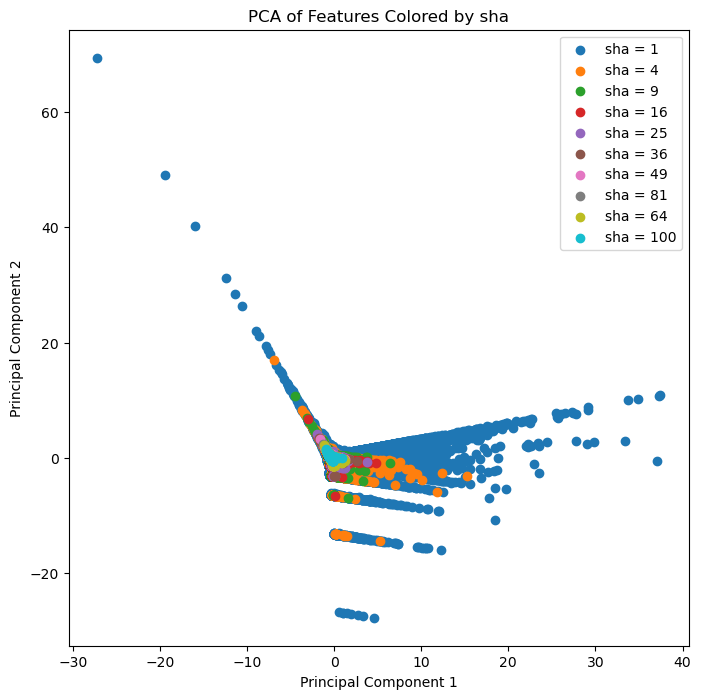

In [13]:
# Plot the PCA results
plt.figure(figsize=(8, 8))
for label in y.unique():
    plt.scatter(X_pca[y == label, 0], X_pca[y == label, 1], label=f'sha = {label}')
plt.title('PCA of Features Colored by sha')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.savefig("CN_curves_bsd_pca.jpg")
plt.show()

## Persistent Diagram using Giotto-TDA

Persistence diagrams array shape: (1, 1646, 3)


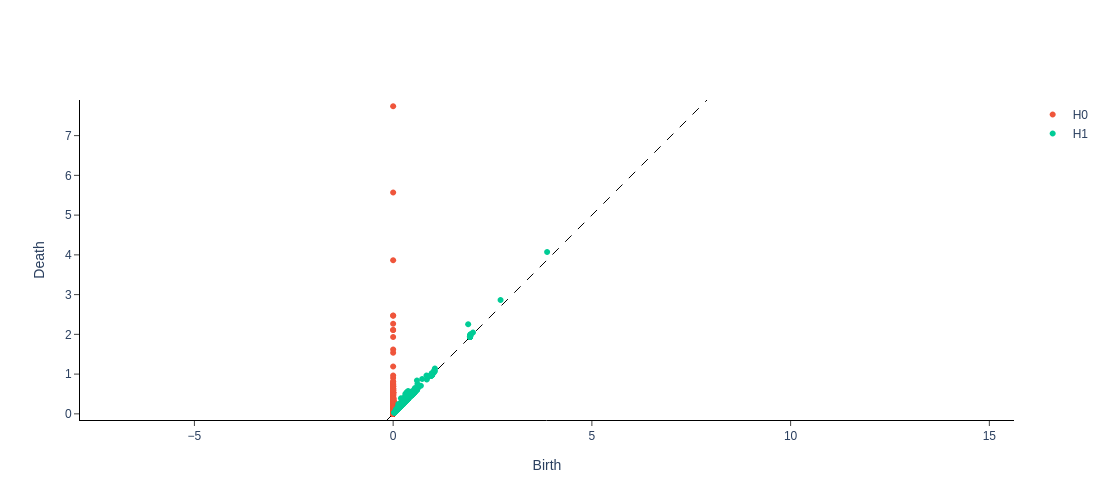

In [4]:
# Run it only for rows less than 15k
# Compute persistent homology of the BSD parameter space X_scaled

from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram

# Example: Load your dataframe (replace with your own loading code)
# X = pd.read_csv("your_file.csv", usecols=['tamagawa', 'special', 'torsion', 'reg', 'omega'])

# --- If you already have X_scaled, skip this step ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# gtda expects shape (n_samples, n_features) for point cloud
# If X_scaled is the whole dataset, it is treated as a point cloud of n_samples points

# Create a Vietoris–Rips persistence transformer
# homology_dimensions=[0, 1, 2] means we compute connected components, loops, and voids
vr_persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=[0, 1]
)

# Compute the persistence diagrams
diagrams = vr_persistence.fit_transform([X_scaled])  # Wrap in list → one point cloud

# diagrams is of shape (n_point_clouds, n_features_in_PD, 3)
# 3 columns: birth, death, homology dimension
print("Persistence diagrams array shape:", diagrams.shape)

# Plot the persistence diagram for this single point cloud
plot_diagram(diagrams[0])

import plotly.io as pio
pio.kaleido.scope.default_format = "png"  # force Kaleido
from gtda.plotting import plot_diagram
fig = plot_diagram(diagrams[0])  # where diagrams[0] is your persistence diagram array
fig.write_image("persistence_diagram.png")
fig.show()


## Mapper graph using Kepler Mapper

In [ ]:
import kmapper as km
colorval = np.c_[np.array(df['rank']),np.array(df['iscongruent']), np.array(df['mod8']), np.array(df['2selmer_rank'])]


alens = X_pca
mapper = km.KeplerMapper(verbose=3)

graph = mapper.map(lens=alens, X=X_scaled, clusterer=sklearn.cluster.DBSCAN(eps=0.6, min_samples=15), cover=km.Cover(15, 0.6), remove_duplicate_nodes=True)
html = mapper.visualize(graph,
                 path_html="pca_sha_cnCurves.html",
                 title="Visualization of BSD data of CN curves via PCA",
                 custom_tooltips=np.array(l),
                 color_values=colorval,
                 color_function_name=['MW rank','isCN','mod8', 'selmer'])